# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [15]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [16]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4276.231165,0.9999,-131.886217,2091.29,1959.403783
OMUSDT,526.319895,2142.518116,0.5010,0.000000,1616.20,1616.200000
BTCUSDT,601.021649,930.213703,0.2175,3.537078,329.19,332.727078
SOLUSDT,281.200518,460.054355,0.1076,0.000000,178.85,178.850000
JASMYUSDT,387.458505,353.723735,0.0827,0.000000,-33.73,-33.730000
ETHUSDT,250.747339,231.355986,0.0541,0.000000,-19.39,-19.390000
TRXUSDT,76.868953,122.463481,0.0286,-10.723889,45.59,34.866111
BBUSDT,60.176053,34.737399,0.0081,-39.733101,-25.44,-65.173101
BNBUSDT,1.142121,1.164387,0.0003,-10.606040,0.02,-10.586040
PEPEUSDT,0.000004,0.000004,0.0000,-38.521986,-0.00,-38.521986


In [20]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [21]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [22]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [23]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [25]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [26]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [27]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [28]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_1600\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [29]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-01-21     93.726816
2025-01-22    -12.018221
2025-01-23    -13.579569
2025-01-24    -64.480882
2025-01-25    260.437294
Name: Total, Length: 125, dtype: float64

In [30]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-01-21    1523.184233
2025-01-22    1511.166011
2025-01-23    1497.586442
2025-01-24    1433.105561
2025-01-25    1693.542854
Name: Total, Length: 125, dtype: float64

In [31]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [32]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [33]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [34]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_1600\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [35]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [36]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [37]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

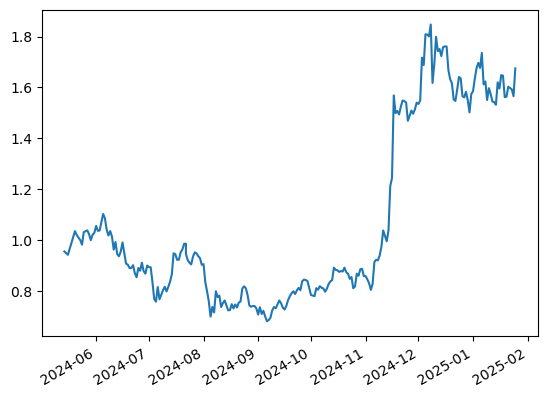

In [38]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [40]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [43]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [44]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [47]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4080
XRPUSDT,0.1898
BNBUSDT,0.1661
SUIUSDT,0.0686
PEPEUSDT,0.0576
RAYUSDT,0.0528
DEXEUSDT,0.0274
AAVEUSDT,0.0168
TRXUSDT,0.0130
ETCUSDT,0.0000


In [48]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.379789
BTCUSDT,0.300000
XRPUSDT,0.138584
SUIUSDT,0.051532
BNBUSDT,0.040662
RAYUSDT,0.040421
PEPEUSDT,0.021757
DEXEUSDT,0.020850
TRXUSDT,0.006405


### Current results

In [50]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [51]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.466968
OMUSDT,0.400860
TRXUSDT,0.132172


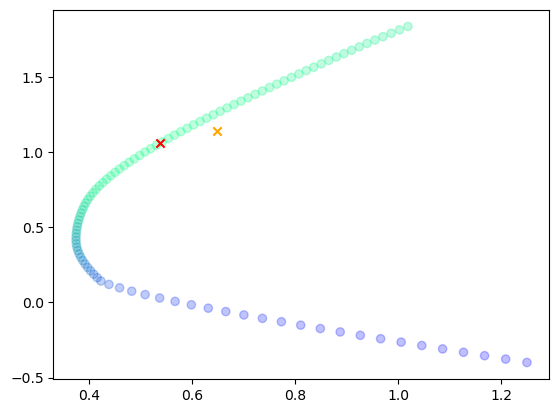

In [52]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [54]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2142.518116,0.501030,0.400860,0.100170
BTCUSDT,930.213703,0.217531,0.466968,-0.249437
SOLUSDT,460.054355,0.107584,0.000000,0.000000
JASMYUSDT,353.723735,0.082719,0.000000,0.000000
ETHUSDT,231.355986,0.054103,0.000000,0.000000
TRXUSDT,122.463481,0.028638,0.132172,-0.103534
BBUSDT,34.737399,0.008123,0.000000,0.000000
BNBUSDT,1.164387,0.000272,0.000000,0.000000
PEPEUSDT,0.000004,0.000000,0.000000,0.000000


In [55]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2142.518116,0.501030,0.379789,0.121241
BTCUSDT,930.213703,0.217531,0.300000,-0.082469
SOLUSDT,460.054355,0.107584,0.000000,0.000000
JASMYUSDT,353.723735,0.082719,0.000000,0.000000
ETHUSDT,231.355986,0.054103,0.000000,0.000000
TRXUSDT,122.463481,0.028638,0.006405,0.022233
BBUSDT,34.737399,0.008123,0.000000,0.000000
BNBUSDT,1.164387,0.000272,0.040662,-0.040390
PEPEUSDT,0.000004,0.000000,0.021757,-0.021757
XRPUSDT,0.000000,0.000000,0.138584,0.000000


# Risk Reward Analysis

In [57]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [58]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

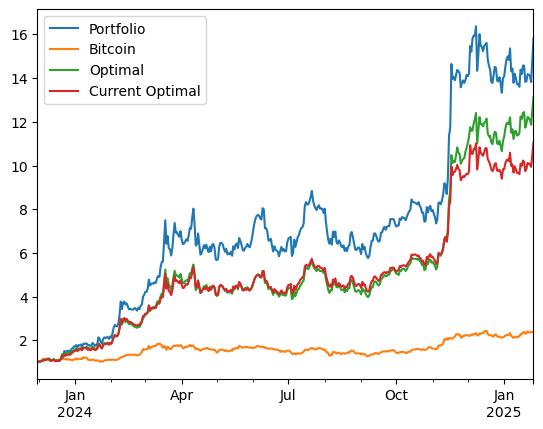

In [59]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [60]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

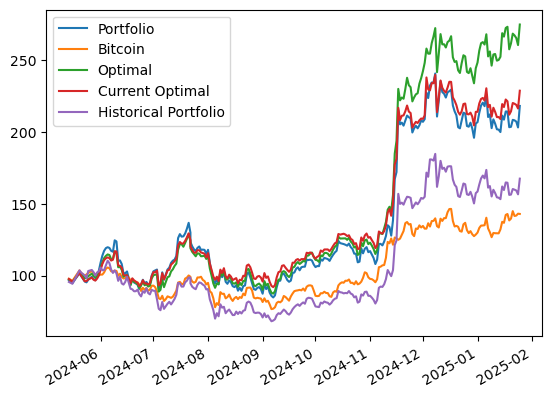

In [61]:
((1+current_perf).cumprod()*100).plot()

In [62]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-01-16,208.533379,136.758041,266.299631,217.318956,159.577157
2025-01-17,214.218173,142.241005,272.308131,222.556822,164.832054
2025-01-18,214.200857,142.893805,273.150764,221.308829,164.645552
2025-01-19,203.270956,138.417370,257.468324,211.992842,156.174667
2025-01-20,203.554456,139.679830,261.635989,214.333299,156.395672
2025-01-21,208.408955,144.886575,268.380940,220.123803,160.268527
2025-01-22,208.066160,141.521058,267.159980,219.597859,159.809659
2025-01-23,207.163908,141.798733,265.320715,218.808348,159.252001
2025-01-24,203.100531,143.102976,260.443666,216.281424,156.577799
2025-01-25,218.079224,142.934147,274.724898,228.670409,167.492235


## Volatilities

In [64]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.625049
 dtype: float64,
 0.6257662898952535)

In [65]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.648604
 dtype: float64,
 0.6486036542526159)

In [66]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.739078
Bitcoin            0.428245
Optimal            0.625766
Current Optimal    0.611779
dtype: float64

In [67]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.44295686965452274

In [68]:
days=120
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

2.4407938687458124

In [69]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.7606506775359223

## Risk Contribution

In [71]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.061208,0.040662,0.004173,0.013970,0.000924,0.013046
BTCUSDT,0.416813,0.300000,0.029366,0.130258,0.042150,0.088108
DEXEUSDT,0.044189,0.020850,0.002664,0.012009,0.000876,0.011133
OMUSDT,22.116862,0.379789,0.921626,0.677499,0.561553,0.115946
PEPEUSDT,0.066031,0.021757,0.003596,0.018871,0.001863,0.017009
RAYUSDT,0.224065,0.040421,0.010835,0.039728,0.005620,0.034109
SUIUSDT,0.120988,0.051532,0.007068,0.032504,0.006068,0.026436
TRXUSDT,0.004879,0.006405,0.000462,0.001741,0.000048,0.001693
XRPUSDT,0.354714,0.138584,0.020209,0.073419,0.022260,0.051159


In [72]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.209707,0.400860,0.637700,0.694192,0.575872,0.118320
BTCUSDT,0.250662,0.466968,0.284144,0.220816,0.123367,0.097450
TRXUSDT,0.065218,0.132172,0.078156,0.084992,0.041825,0.043167


In [73]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.508889,0.50,0.753942,0.732547,0.616668,0.115878
BTCUSDT,0.118093,0.22,0.126887,0.082230,0.018847,0.063383
SOLUSDT,0.043508,0.11,0.057612,0.071749,0.012619,0.059131
JASMYUSDT,-0.012570,0.08,0.025307,0.070875,0.017966,0.052909
ETHUSDT,-0.001234,0.05,0.018302,0.021725,0.001745,0.019980
TRXUSDT,0.014803,0.03,0.016815,0.011455,0.001483,0.009972
BBUSDT,-0.006973,0.01,0.001136,0.009419,0.000371,0.009047


# Value At Risk

## Historical

### Optimal Weights

In [77]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.052708895990112206, -0.07409724402174125)

### Current Weights

In [79]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.0485031203574055, -0.07329523324663928)

In [80]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [81]:
var=historical_var.iloc[row]
var

OMUSDT      -0.010682
BTCUSDT     -0.012648
SOLUSDT     -0.008514
JASMYUSDT   -0.009760
ETHUSDT     -0.003542
TRXUSDT     -0.002400
BBUSDT      -0.000688
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048234
Name: 2024-12-18 00:00:00, dtype: float64

In [82]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.043862
BTCUSDT     -0.007930
SOLUSDT     -0.007311
JASMYUSDT   -0.007879
ETHUSDT     -0.002455
TRXUSDT     -0.001088
BBUSDT      -0.000980
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.071505
dtype: float64

## Parametric

### Optimal Weights

In [85]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06483942432871172, -0.08310621488144329)

### Current Weights

In [87]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.0672057415657177, -0.08613917932880345)

## Multivariate

### Optimal Weights

In [90]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.060790160391907086, -0.07716600174965507)

### Current Weights

In [92]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.062346884722146445, -0.0805898654075487)

In [93]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.046873
BTCUSDT     -0.004729
SOLUSDT     -0.004467
JASMYUSDT   -0.004028
ETHUSDT     -0.001325
TRXUSDT     -0.000467
BBUSDT      -0.000685
Portfolio   -0.062573
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [97]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05823795932999041, -0.07460433323628653)

### Current Weights

In [99]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06184906874292463, -0.07911698127020696)

In [100]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.045894
BTCUSDT     -0.004723
SOLUSDT     -0.004668
JASMYUSDT   -0.004550
ETHUSDT     -0.001554
TRXUSDT     -0.000729
BBUSDT      -0.000701
Portfolio   -0.062820
dtype: float64

## Student Copula

### Optimal Weights

In [103]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05751060649218774, -0.0736597899435927)

### Current Weights

In [105]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0631590577571154, -0.0815512234507867)

In [106]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.046529
BTCUSDT     -0.005089
SOLUSDT     -0.004368
JASMYUSDT   -0.005071
ETHUSDT     -0.001494
TRXUSDT     -0.000879
BBUSDT      -0.000574
Portfolio   -0.064004
dtype: float64

## Gumbel Copula

### Optimal Weights

In [109]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1056989241939834, -0.14991982050152966)

### Current Weights

In [111]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12061369819184822, -0.16607892116422282)

In [112]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.111585
BTCUSDT      0.000770
SOLUSDT     -0.001392
JASMYUSDT   -0.002893
ETHUSDT     -0.000491
TRXUSDT      0.000031
BBUSDT      -0.000379
Portfolio   -0.115940
dtype: float64

## Monte Carlo

### Optimal

In [115]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [116]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06637552433883152, -0.08256232823452705)

### Current Weights

In [118]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06955924592976435, -0.08626678869349012)

In [119]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.049202
BTCUSDT     -0.006146
SOLUSDT     -0.005451
JASMYUSDT   -0.005069
ETHUSDT     -0.001582
TRXUSDT     -0.000646
BBUSDT      -0.000629
Portfolio   -0.068725
dtype: float64

## VaR Violation

In [121]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056056,-0.098988,-0.085659,-0.018948
2024-01-15,-0.056056,-0.098985,-0.083569,0.016017
2024-01-16,-0.056056,-0.098663,-0.082838,0.043733
2024-01-17,-0.056056,-0.100089,-0.086169,-0.023636
2024-01-18,-0.056056,-0.102631,-0.090282,-0.038839
...,...,...,...,...
2025-01-22,-0.057493,-0.065977,-0.061397,-0.004549
2025-01-23,-0.057493,-0.065554,-0.062719,-0.006885
2025-01-24,-0.057493,-0.066093,-0.063799,-0.018382
2025-01-25,-0.057493,-0.066901,-0.061633,0.054834


In [122]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.036585,-0.084050,-0.082703,-0.015897
2024-05-29,-0.036585,-0.081519,-0.078712,-0.008381
2024-05-30,-0.036585,-0.070641,-0.069046,0.029287
2024-05-31,-0.036585,-0.071968,-0.065383,0.038098
2024-06-01,-0.036585,-0.075741,-0.068812,0.054358
...,...,...,...,...
2025-01-22,-0.050199,-0.065438,-0.063496,-0.001645
2025-01-23,-0.050199,-0.065202,-0.065024,-0.004336
2025-01-24,-0.046629,-0.060172,-0.061585,-0.019614
2025-01-25,-0.046629,-0.072840,-0.069825,0.073750


<Axes: >

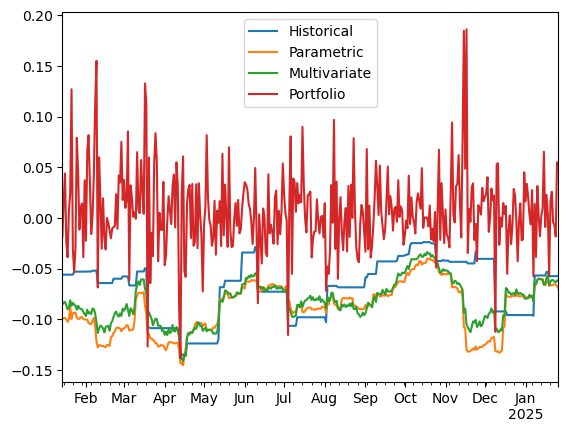

In [123]:
var_data.plot()

<Axes: >

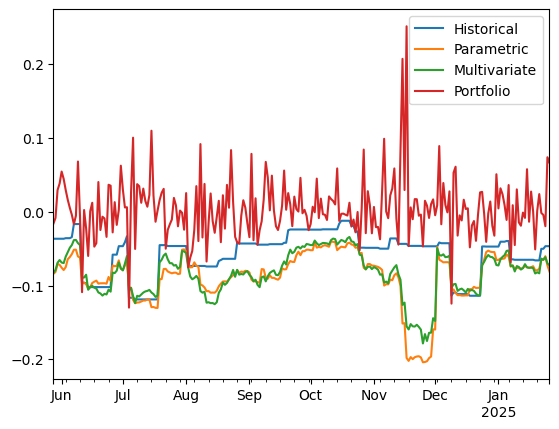

In [124]:
current_var_data.plot()

In [125]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.023747,0.010554,0.015831
Kupiec Stat,6.770042,18.06826,12.559756
P-value,0.00927,0.000021,0.000394


In [126]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.069672,0.016393,0.012295
Kupiec Stat,1.780521,7.765584,10.343463
P-value,0.182085,0.005325,0.001299


# Principal Component Analysis

## Historical PCA

In [129]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77640636, 0.07158729, 0.05746558, 0.05192842, 0.04261234])

In [130]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.016191
ADAUSDT      0.016510
ALGOUSDT     0.018747
APTUSDT      0.016857
ARBUSDT      0.018068
ATOMUSDT     0.016516
AVAXUSDT     0.018285
BCHUSDT      0.015336
BNBUSDT      0.008536
BONKUSDT     0.023047
BTCUSDT      0.009583
CRVUSDT      0.019418
DEXEUSDT     0.014277
DOGEUSDT     0.017647
DOTUSDT      0.017404
ENSUSDT      0.020377
EOSUSDT      0.017438
ETCUSDT      0.015927
ETHUSDT      0.012545
FDUSDUSDT    0.000043
FETUSDT      0.021909
FILUSDT      0.019025
FLOKIUSDT    0.023162
FLOWUSDT     0.018612
GALAUSDT     0.022429
GRTUSDT      0.021014
HBARUSDT     0.018294
ICPUSDT      0.017029
IMXUSDT      0.019080
INJUSDT      0.019422
IOTAUSDT     0.019656
JASMYUSDT    0.019508
LDOUSDT      0.019588
LINKUSDT     0.016384
LTCUSDT      0.012586
MKRUSDT      0.013055
NEARUSDT     0.020783
OMUSDT       0.010783
OPUSDT       0.018683
PEPEUSDT     0.023700
QNTUSDT      0.014524
RAYUSDT      0.018497
SANDUSDT     0.020432
SEIUSDT      0.020519
SHIBUSDT     0.017988
SOLUSDT   

<Axes: >

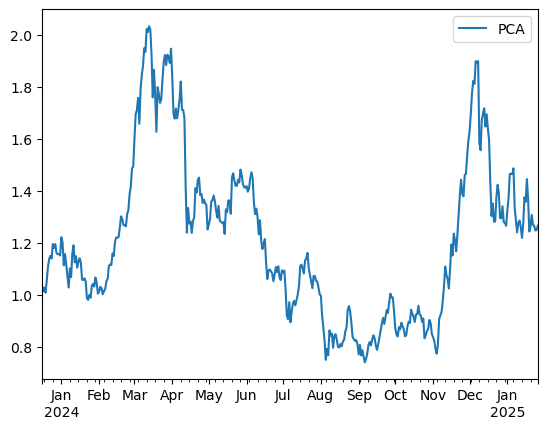

In [131]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

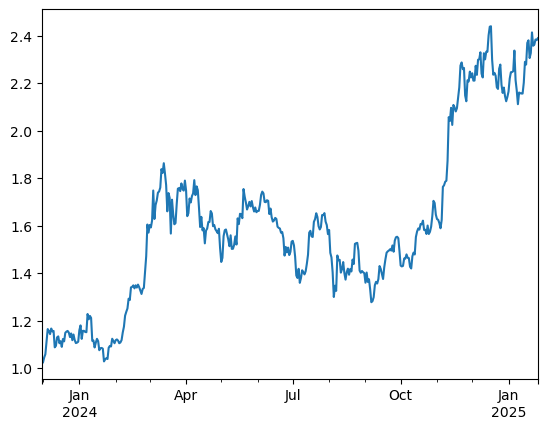

In [132]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [133]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.425143
WBETHUSDT    0.436537
ETHUSDT      0.436955
ATOMUSDT     0.456514
DOTUSDT      0.459542
ETCUSDT      0.461972
ADAUSDT      0.501110
WBTCUSDT     0.508992
BTCUSDT      0.509300
EOSUSDT      0.525140
AVAXUSDT     0.531499
IOTAUSDT     0.548978
FILUSDT      0.550196
ARBUSDT      0.564200
GRTUSDT      0.576893
XTZUSDT      0.581020
LINKUSDT     0.593196
IMXUSDT      0.606006
SOLUSDT      0.606610
dtype: float64

<Axes: >

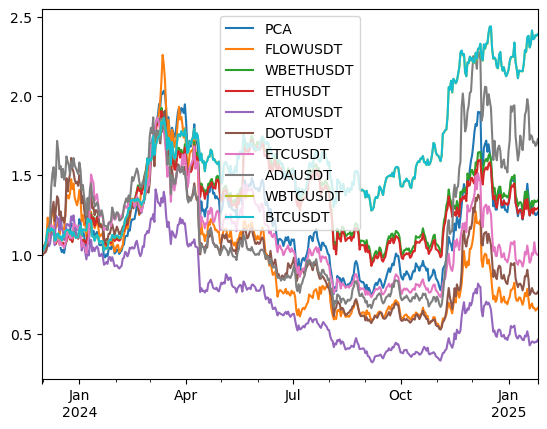

In [134]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

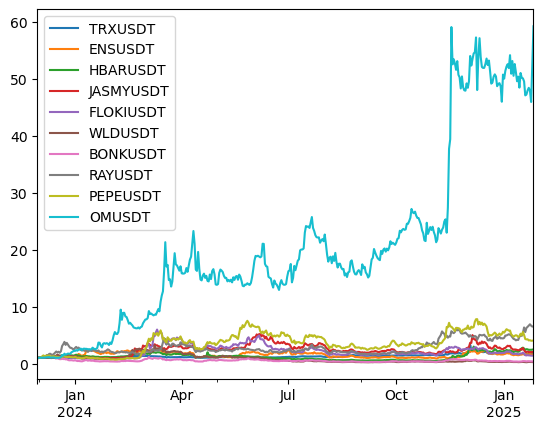

In [135]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [137]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.55795565, 0.14611441, 0.12505952, 0.09934408, 0.07152633])

In [138]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.093652
BTCUSDT      0.061119
SOLUSDT      0.098640
JASMYUSDT    0.173000
ETHUSDT      0.084722
TRXUSDT      0.054453
BBUSDT       0.209848
BNBUSDT      0.065994
PEPEUSDT     0.158570
Name: PC1, dtype: float64

<Axes: >

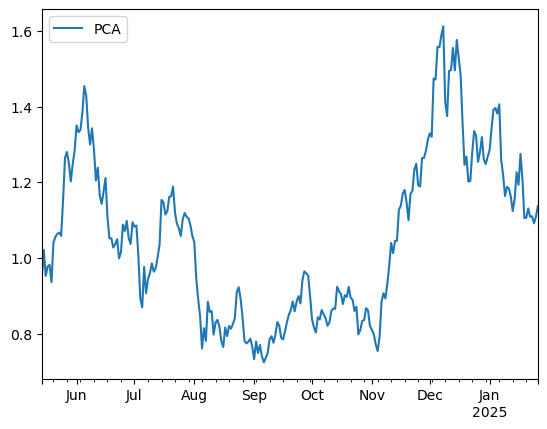

In [139]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

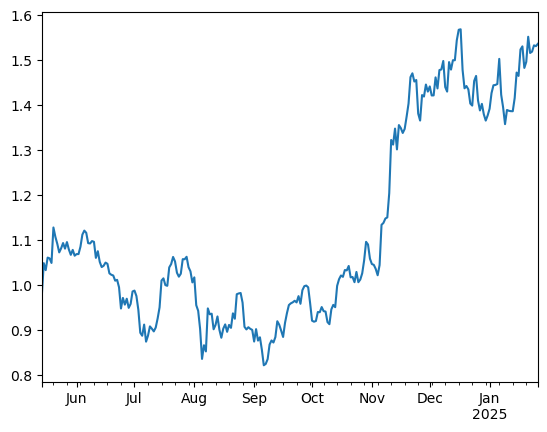

In [140]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [141]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.423878
BNBUSDT      0.448411
BTCUSDT      0.464499
SOLUSDT      0.477525
JASMYUSDT    0.673375
PEPEUSDT     0.731807
BBUSDT       0.761673
TRXUSDT      0.896471
OMUSDT       0.939803
dtype: float64

<Axes: >

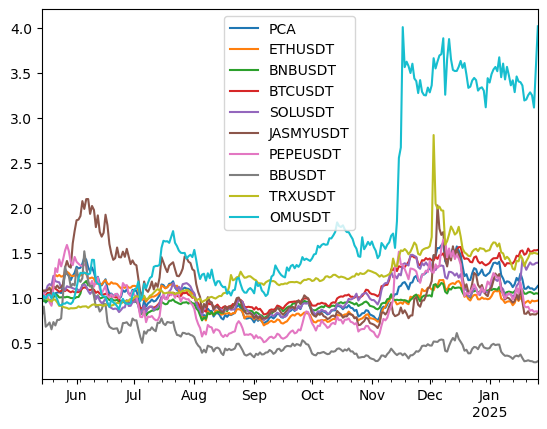

In [142]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [144]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.896707
BBUSDT       1.554962
JASMYUSDT    1.314958
SOLUSDT      1.152942
BTCUSDT      1.000000
ETHUSDT      0.968003
OMUSDT       0.871366
BNBUSDT      0.658693
TRXUSDT      0.315338
Name: BTCUSDT, dtype: float64

In [145]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.215443
PEPEUSDT     1.947511
BBUSDT       1.939155
SOLUSDT      1.274677
ETHUSDT      1.142211
TRXUSDT      1.033803
BTCUSDT      1.000000
OMUSDT       0.788142
BNBUSDT      0.623735
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [147]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [148]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
JASMYUSDT,0.237879
BNBUSDT,0.237449
ETHUSDT,0.210933
BBUSDT,0.177028
BTCUSDT,0.176005
SOLUSDT,0.117625
TRXUSDT,0.060066
PEPEUSDT,0.037107
OMUSDT,-0.032785


### Regression to PCA

In [150]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.9696335842833996

In [151]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.281779
BNBUSDT      1.166965
ETHUSDT      1.011766
PCA          1.000000
SOLUSDT      0.737229
JASMYUSDT    0.435834
PEPEUSDT     0.405404
BBUSDT       0.372924
OMUSDT       0.237296
TRXUSDT      0.235047
dtype: float64

In [152]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      2.561894
BTCUSDT      1.886259
ETHUSDT      1.114352
PCA          1.000000
TRXUSDT      0.953557
BBUSDT       0.744558
PEPEUSDT     0.662927
JASMYUSDT    0.575613
OMUSDT       0.232489
SOLUSDT      0.131986
dtype: float64

### Correlation Matrix

<Axes: >

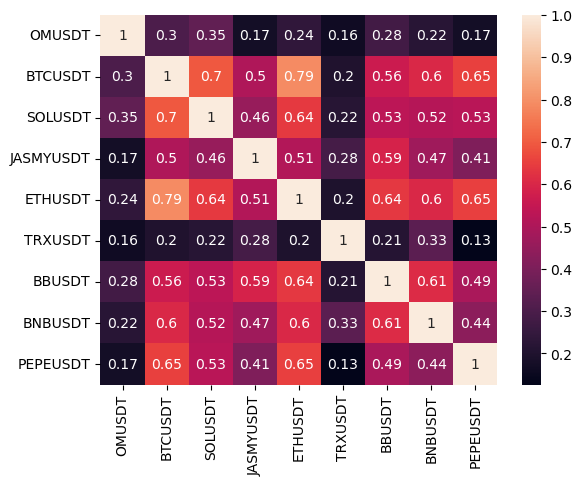

In [154]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

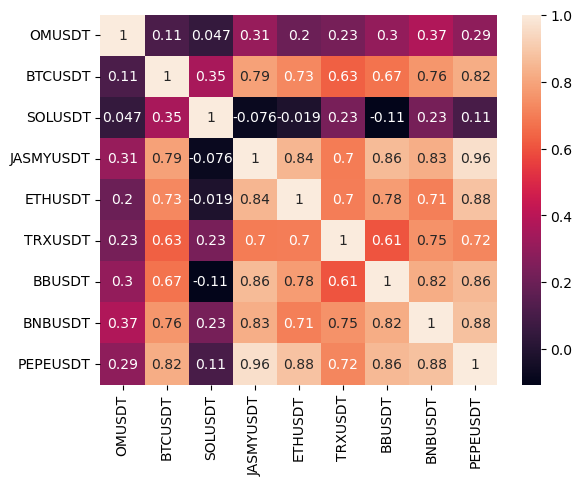

In [155]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [157]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.000000,0.150852,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.112009,0.000000,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [158]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-06-20,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2024-07-20,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.725649,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2024-08-19,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2024-09-18,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.213636,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2024-10-18,0.003767,0.0,0.0,0.003991,0.0,0.0,0.0,0.0,0.0,0.0,...,0.303207,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2024-11-17,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.407475,0.0
2024-12-17,0.333243,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.017227,0.0,0.0,0.271285,0.0
2025-01-16,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.371129,0.0
2025-01-26,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [159]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

DEXEUSDT    0.545121
SOLUSDT     0.246204
LDOUSDT     0.126835
LINKUSDT    0.078072
AAVEUSDT    0.003767
WBTCUSDT    0.000000
Name: 2025-01-26 00:00:00, dtype: float64